# Benchmark: PXD014777 HeLa, Yeast and Ecoli dataset

This notebook contains code to benchmark the PIPP model on [PXD014777 dataset](https://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD014777) - Tenzer.nomatching_MaxQuant.txt.zip and HeLa10replicates2h-1.0.10.4_MaxQuant.txt.zip. Here, we'll use two txt files from the datasets:

- HeLa10replicates2h-1.0.10.4_MaxQuant.txt.zip - allPeptides.txt: All the peptides with MS-1 data for HeLa
- Tenzer.nomatching_MaxQuant.txt.zip - evidence.txt: Contains both MS-1 and MS-2 data for the 3 species: Ecoli, Yeast and HeLa

We'll use PIPP to compute the embeddings of each MS-1 datapoint. Followed by peptide identity propagation using the MS1/MS2 data as the support data. Since multiple species are available in the MS2 dataset, and only HeLU in the MS1 dataset, we'll also compute false transfer rates.

Let's start with the imports.

In [1]:
%%capture

%matplotlib inline

%load_ext autoreload
%autoreload 2

from collections import defaultdict
import re
import os

import pipp
import pipp.utils

import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F

from pynndescent import NNDescent

np.random.seed(0)

Let's define the paths to the data and the pretrained model.

In [2]:
PEPTIDES_PATH = "../../data/HeLa10replicates/txt/allPeptides.txt"
EVIDENCE_PATH = "../../data/tenzer_nomatching/txt/evidence.txt"

PRETRAINED_MODEL_PATH = "../../data/PXD019086_PXD010012_combined_evidence_90Kto20Ksplit_5query_1shot_fullmodel_featuresScaled_allPeptidesTxtFeatures_modSeqSpecies_hidden64_latent10_maxEpoch300_164trainways_xlatent_conditionalEmbedding.pth"

## Data Preparation

Let's load and clean the data.

In [3]:
MS1_raw_data = pd.read_csv(PEPTIDES_PATH, sep='\t', header=0)

In [4]:
MS2_raw_data = pd.read_csv(EVIDENCE_PATH, sep='\t', header=0, low_memory=False)

Let's look at the dimensions of the data.

In [5]:
print('MS1 data shape:     {}'.format(MS1_raw_data.shape))
print('MS1+MS2 data shape: {}'.format(MS2_raw_data.shape))

MS1 data shape:     (4101555, 24)
MS1+MS2 data shape: (219367, 70)


### MS1 data preprocessing

Let's look at the features available in the MS1 data:

In [6]:
MS1_raw_data.columns.unique()

Index(['Raw file', 'Charge', 'm/z', 'Mass', 'Resolution',
       'Number of data points', 'Number of frames', 'Number of isotopic peaks',
       'Isotope correlation', 'Mass fractional part', 'Mass deficit',
       'Retention time', 'Retention length', 'Retention length (FWHM)',
       'Min frame index', 'Max frame index', 'Ion mobility index',
       'Ion mobility index length', 'Ion mobility index length (FWHM)',
       'Intensity', 'Intensities', 'Number of pasef MS/MS', 'Pasef MS/MS IDs',
       'MS/MS scan number'],
      dtype='object')

Let's filter out low quality peptides.

In [7]:
# filter out low quality peptides
MS1_data = MS1_raw_data.loc[(MS1_raw_data['Charge'] != 1) & (MS1_raw_data['Intensity'] > 0)]

In [8]:
MS1_raw_peptides_per_run = [np.sum(MS1_raw_data['Raw file'] == run) for run in MS1_raw_data['Raw file'].unique()]
MS1_peptides_per_run = [np.sum(MS1_data['Raw file'] == run) for run in MS1_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

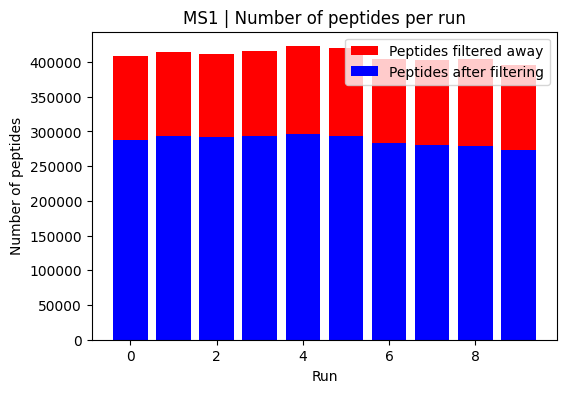

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(MS1_raw_peptides_per_run)), MS1_raw_peptides_per_run, color='red')
ax.bar(range(len(MS1_peptides_per_run)), MS1_peptides_per_run, color='blue')
ax.legend(['Peptides filtered away', 'Peptides after filtering'])

ax.set_title("MS1 | Number of peptides per run")
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [10]:
print(f"After filtering | MS1 data points: {MS1_data.shape[0]} ({MS1_data.shape[0] / MS1_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS1 data points: 2871496 (70.01%)


### MS2 (MSMS) data preprocessing

Let's look at the features available in the MS2 data:

In [11]:
MS2_raw_data.columns.unique()

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Experiment', 'MS/MS m/z',
       'Charge', 'm/z', 'Mass', 'Resolution',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'CCS length', 'Match time difference', 'Match m/z difference',
       '

Let's filter out low quality peptides.

In [12]:
# filter out low quality peptides
MS2_data = MS2_raw_data.loc[(MS2_raw_data['Charge'] != 1) & (MS2_raw_data['Intensity'] > 0)]

# keep the most intense peptides
MS2_data = MS2_data.loc[MS2_data.groupby(['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()]

# remove contaminants
MS2_data = MS2_data.loc[[(not bool(re.search('CON__|REV__', i))) for i in MS2_data['Leading razor protein'].tolist()]]

# define identifier for each peptide
MS2_data['PrecursorID'] = MS2_data['Modified sequence'].astype(str).str.cat(MS2_data['Charge'].astype(str), sep='')

In [13]:
MS2_raw_peptides_per_run = [np.sum(MS2_raw_data['Raw file'] == run) for run in MS2_raw_data['Raw file'].unique()]
MS2_peptides_per_run = [np.sum(MS2_data['Raw file'] == run) for run in MS2_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

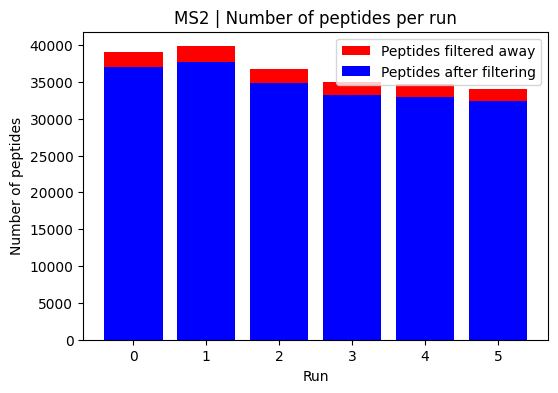

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(MS2_raw_peptides_per_run)), MS2_raw_peptides_per_run, color='red')
ax.bar(range(len(MS2_peptides_per_run)), MS2_peptides_per_run, color='blue')
ax.legend(['Peptides filtered away', 'Peptides after filtering'])

ax.set_title("MS2 | Number of peptides per run")
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [15]:
print(f"After filtering | MS2 data points: {MS2_data.shape[0]} ({MS2_data.shape[0] / MS2_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS2 data points: 208091 (94.86%)


Let's see how many runs a peptide is present in.

In [16]:
peptides_abundances = MS2_data['PrecursorID'].value_counts()

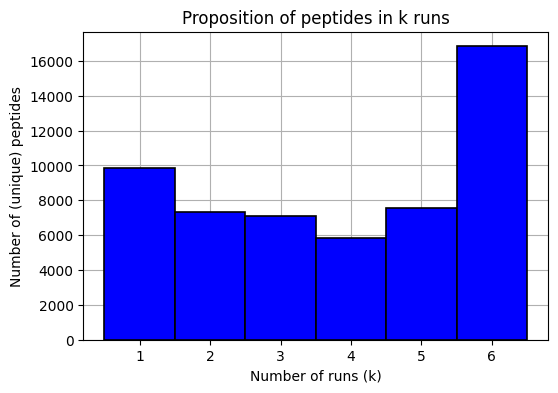

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(peptides_abundances, bins=range(1, np.max(peptides_abundances)+2), color='blue', edgecolor='black', linewidth=1.2, align='left')
ax.set_xticks(range(1, np.max(peptides_abundances)+1))
ax.set_title('Proposition of peptides in k runs')
ax.set_xlabel('Number of runs (k)')
ax.set_ylabel('Number of (unique) peptides')
ax.grid(True)
ax.set_axisbelow(True)

Let's add a column with species.

In [18]:
yeast_filter = MS2_data['Leading razor protein'].str.contains('YEAST')
ecoli_filter = MS2_data['Leading razor protein'].str.contains('ECOLI')
hela_filter = ~(yeast_filter | ecoli_filter)

MS2_data['Species'] = 'Unknown'
MS2_data.loc[yeast_filter, 'Species'] = 'Yeast'
MS2_data.loc[ecoli_filter, 'Species'] = 'Ecoli'
MS2_data.loc[hela_filter, 'Species'] = 'HeLa'

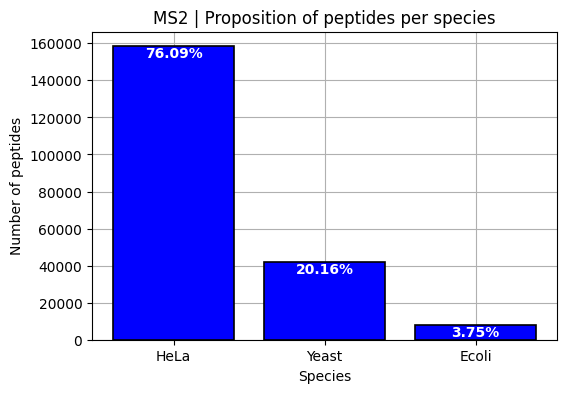

In [19]:
species = MS2_data['Species']

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(species.value_counts().index, species.value_counts(), color='blue', edgecolor='black', linewidth=1.2)
ax.set_title('MS2 | Proposition of peptides per species')
ax.set_xlabel('Species')
ax.set_ylabel('Number of peptides')
ax.grid(True)
ax.set_axisbelow(True)

for i, v in enumerate(species.value_counts()):
    y = v - 4000
    text = f"{v / MS2_data.shape[0] * 100:.2f}%"
    ax.text(i, y, text, ha='center', va='center', fontweight='bold', color='white')

### Feature Extraction

Let's extract the features which the model takes as input.

It seems like the two datasets use a different name for 'Ion mobilility index length' / 'Ion mobility length'. Let's rename one of them to be consistent between the datasets.

In [20]:
MS1_data = MS1_data.copy()
MS1_data.rename(columns={'Ion mobility index length': 'Ion mobility length'}, inplace=True)

In [21]:
features = ['Charge','Mass', 'm/z', 'Retention time','Retention length', 'Ion mobility index', 'Ion mobility length','Number of isotopic peaks']

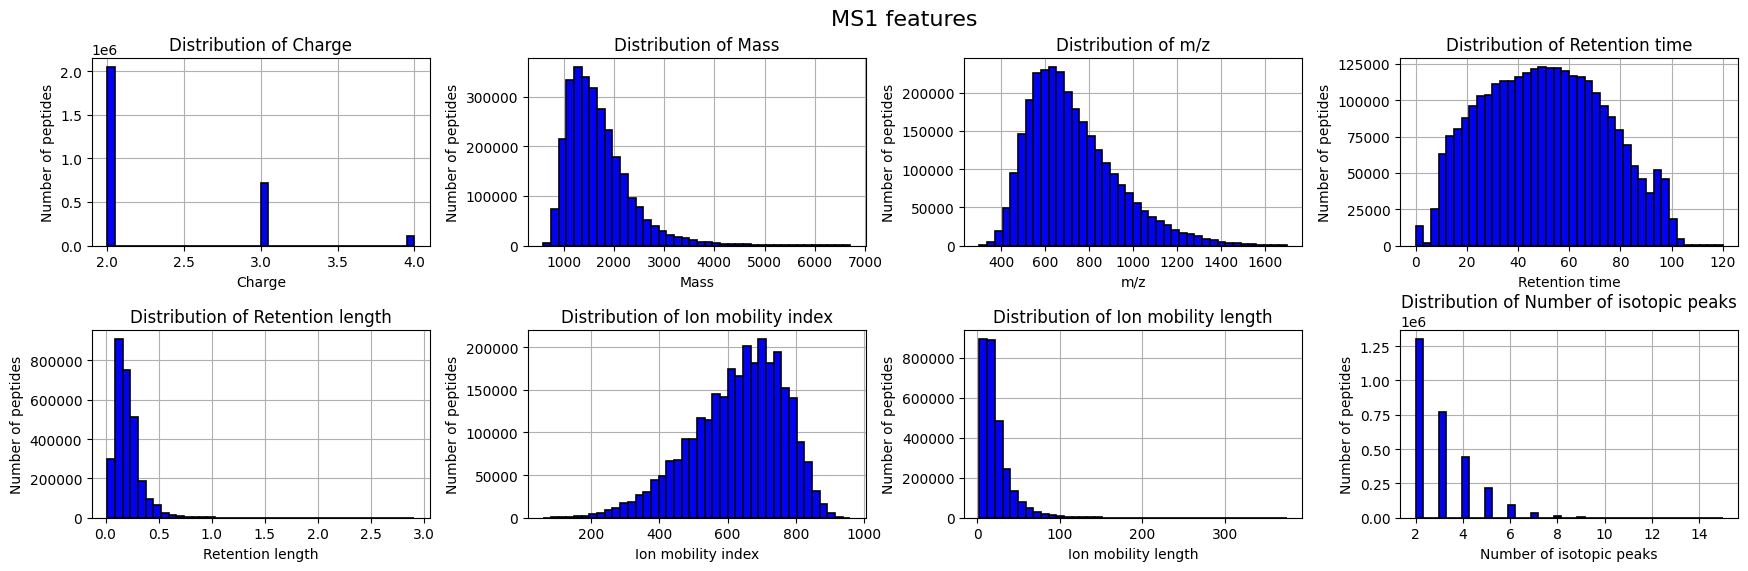

In [22]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('MS1 features', fontsize=16)

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    ax.hist(MS1_data[feature], bins=40, color='blue', edgecolor='black', linewidth=1.2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title(f'Distribution of {feature}')
    ax.grid(True)
    ax.set_axisbelow(True)

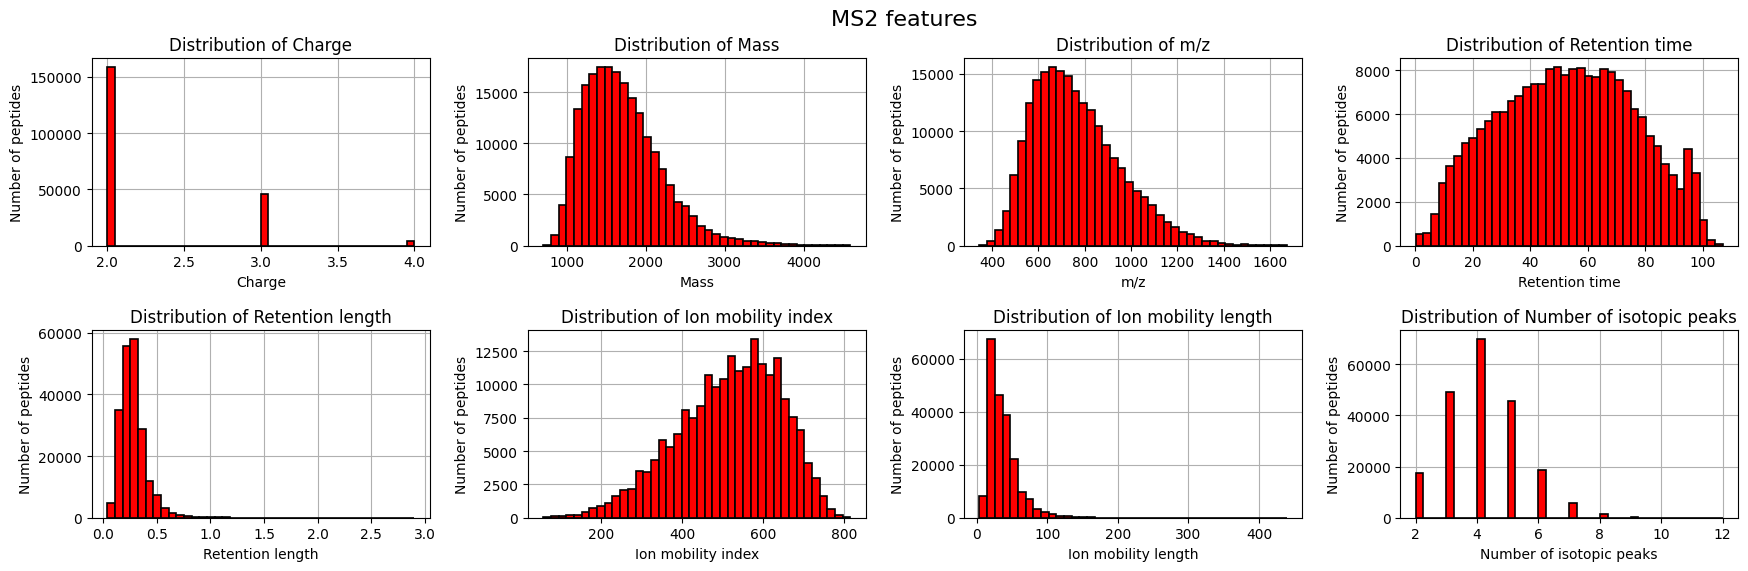

In [23]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('MS2 features', fontsize=16)

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    ax.hist(MS2_data[feature], bins=40, color='red', edgecolor='black', linewidth=1.2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title(f'Distribution of {feature}')
    ax.grid(True)
    ax.set_axisbelow(True)

Let's plot features by species as well.

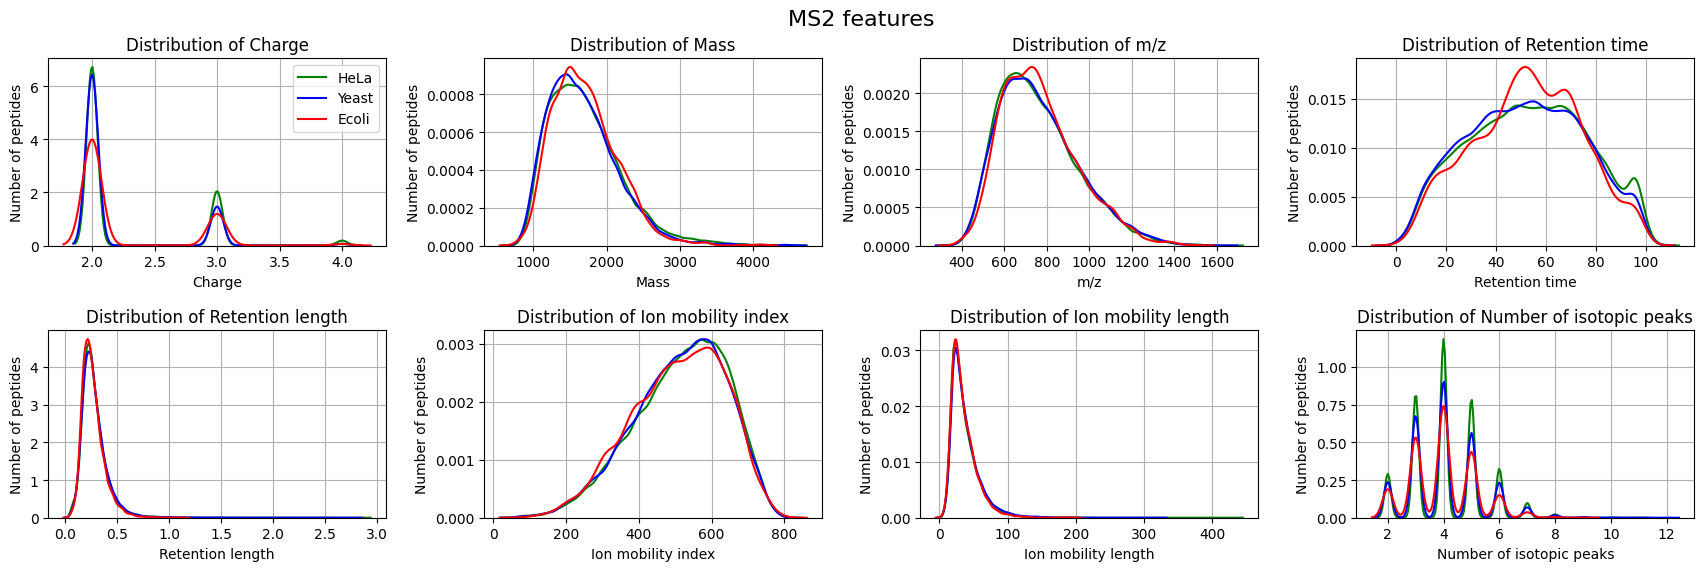

In [24]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('MS2 features', fontsize=16)

yeast_filter = MS2_data['Species'] == 'Yeast'
ecoli_filter = MS2_data['Species'] == 'Ecoli'
hela_filter = MS2_data['Species'] == 'HeLa'

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    sns.kdeplot(MS2_data[hela_filter][feature], color='green', label='HeLa', ax=ax)
    sns.kdeplot(MS2_data[yeast_filter][feature], color='blue', label='Yeast', ax=ax)
    sns.kdeplot(MS2_data[ecoli_filter][feature], color='red', label='Ecoli', ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title(f'Distribution of {feature}')
    ax.grid(True)
    ax.set_axisbelow(True)

axs[0][0].legend()

In [25]:
MS1_features = MS1_data[features]
MS2_features = MS2_data[features]

## PIPP model

### Computing the Embeddings

Let's load the model and compute the embeddings.

In [26]:
model = pipp.Peptideprotonet.load(PRETRAINED_MODEL_PATH)

In [27]:
MS1_embeddings = model.get_latent_representations(MS1_features)

In [28]:
MS2_embeddings = model.get_latent_representations(MS2_features)

Let's look at the embedding space.
We'll look at a subset of peptides due to memory limitations.

In [29]:
N = 50_000
random_indices = np.random.choice(range(len(MS2_embeddings)), size=N, replace=False)

Let's also add some "random" peptides to ensure all possible runs of at least a few peptides are included.

In [30]:
high_coverage_peptides_to_include = [
    '_(ac)AAAAAAAAAAGAAGGR_2',
    '_GLGAAEFGGAAGNVEAPGETFAQR_2',
    '_GLGLSPDLVVCR_2',
    '_SSLDNIEMAYAR_2',
    '_GLGHQVATDALVAMEK_3',
    '_SSMQIDNAPTPHNTPASVLNPSYLK_3',
    '_GLESLPPLRPQQNPVLPVAGER_3',
    '_GLELIASENFCSR_2',
    '_SSLAMIGHDGPNDMK_2',
]

low_coverage_peptides_to_include = [
    '_FTDEDEQGLR_2',
    '_SLPVPQLVPETEDEKK_2',
    '_EAEPDLLAVLR_2',
    '_SLPQTLILNPIR_2',
    '_DETGELSSADEK_2',
    '_GYLTDLNSMIPTHGGDINDIK_3',
    '_GYNPGLLVHPDLAYLQAEGGGDR_3',
    '_EVMQEVAQLSQFDEELYK_3',
    '_VPPATAFEGHMLLSGLEPFR_3',
    '_DEMLGLVPMR_2',
]

peptides_to_include = high_coverage_peptides_to_include + low_coverage_peptides_to_include

custom_indices = [MS2_data.index[MS2_data['PrecursorID'] == peptide].tolist() for peptide in peptides_to_include]
custom_indices = [peptide for peptide_runs in custom_indices for peptide in peptide_runs]
custom_indices = [MS2_data.index.get_loc(i) for i in custom_indices]

# print(peptides_abundances)

In [31]:
indices = np.unique(np.concatenate((random_indices, custom_indices)))

In [32]:
MS2_data_subset = MS2_data.iloc[indices]
MS2_embeddings_subset = MS2_embeddings[indices]

Let's compute the UMAP for plotting.

In [33]:
reducer = umap.UMAP(metric = 'cosine')
umap_embedding = reducer.fit_transform(MS2_embeddings_subset)

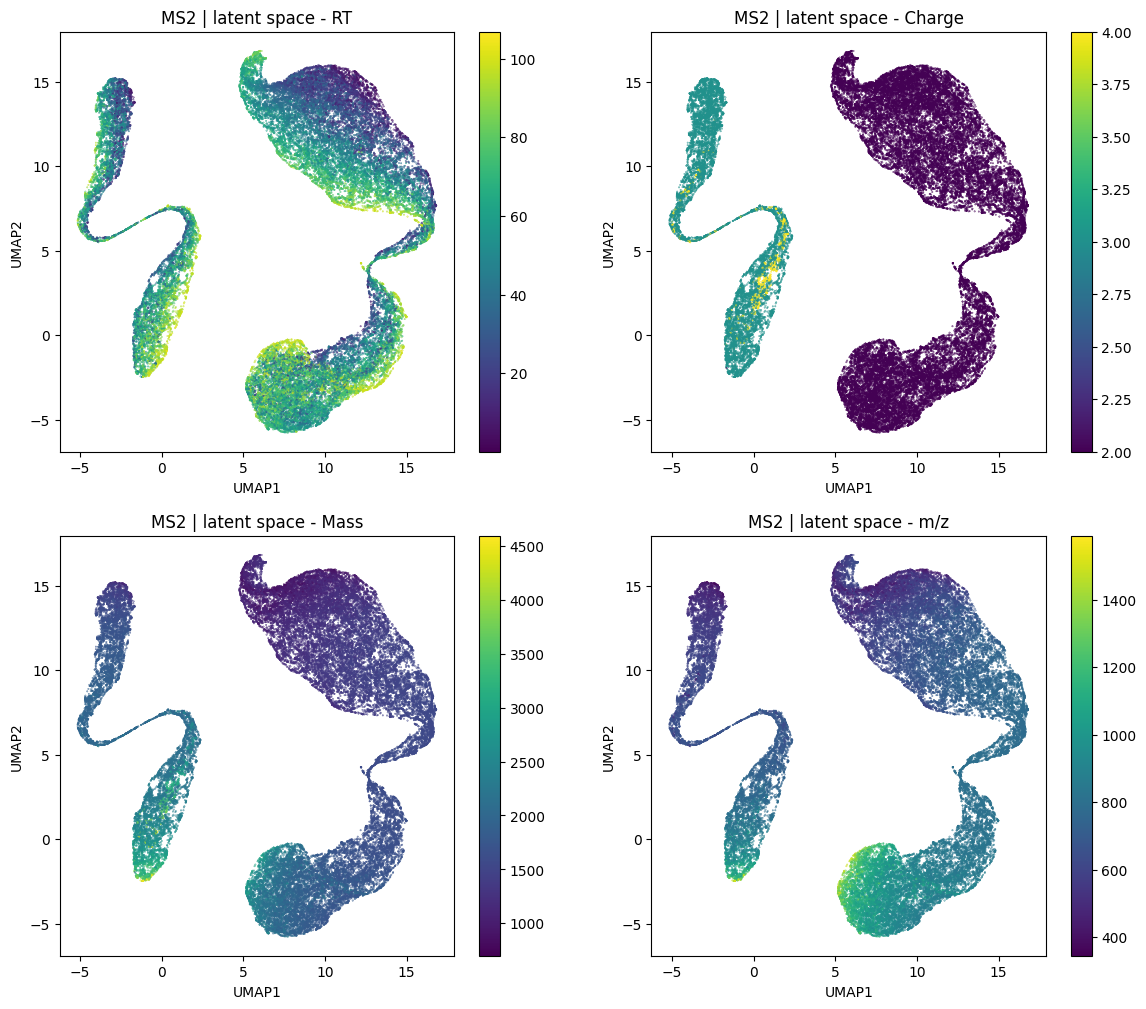

In [35]:
fig, axs = plt.subplots(figsize=(14, 12), ncols=2, nrows=2)

ax = axs[0][0]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Retention time'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - RT')
fig.colorbar(sp)

ax = axs[0][1]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Charge'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - Charge')
fig.colorbar(sp)

ax = axs[1][0]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Mass'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - Mass')
fig.colorbar(sp)

ax = axs[1][1]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['m/z'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - m/z')
fig.colorbar(sp)

Let's plot the latent space for each specie. We'll scale based on proportion of peptides in each specie.

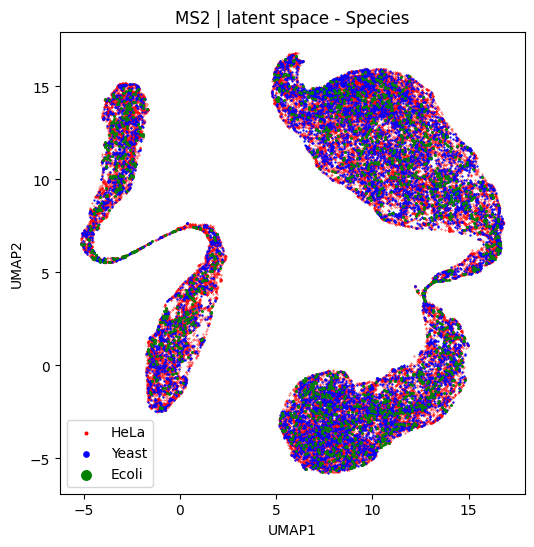

In [36]:
colors = ['red', 'blue', 'green']
color_map = {species: color for species, color in zip(MS2_data_subset['Species'].unique(), colors)}
species_size = {'HeLa': .1, 'Yeast': .4, 'Ecoli': 1.3}

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - Species')

for species, color in color_map.items():
    umap1 = umap_embedding[MS2_data_subset['Species'] == species][:,0]
    umap2 = umap_embedding[MS2_data_subset['Species'] == species][:,1]
    ax.scatter(umap1, umap2, c=color, s=species_size[species], label=species)

ax.legend(markerscale=6)

Let's also plot the latent space of the MS2 data together with some low coverage and high coverage peptides.

Text(0.5, 1.0, 'MS2 | latent space - low coverage peptides')

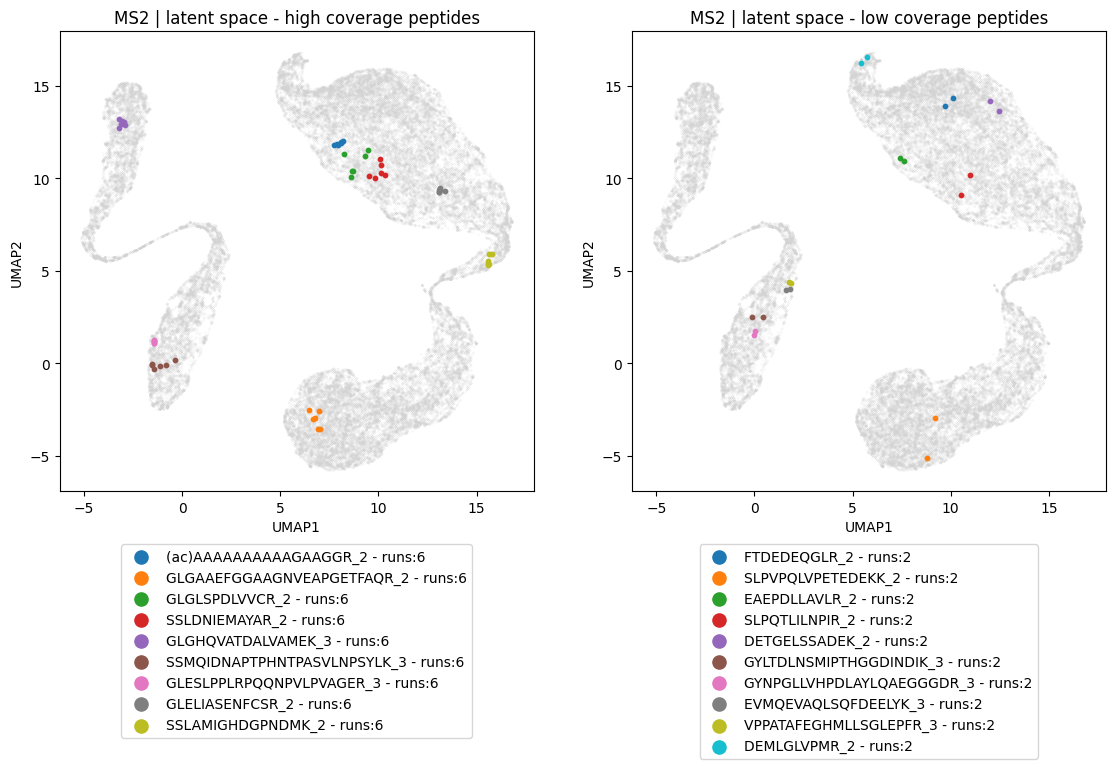

In [37]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
fig.tight_layout(pad=4.0)

# high coverage peptides
ax = axs[0]
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.01, color='lightgrey')

for i, peptide in enumerate(high_coverage_peptides_to_include):
    peptide_ref_indices = np.where(MS2_data_subset['PrecursorID'] == peptide)
    ax.scatter(umap_embedding[peptide_ref_indices,0], umap_embedding[peptide_ref_indices,1], s=10, color=plt.cm.tab10(i), label=f"{peptide[1:]} - runs:{peptides_abundances[peptide]}")

ax.legend(markerscale=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - high coverage peptides')

# low coverage peptides
ax = axs[1]
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.01, color='lightgrey')

for i, peptide in enumerate(low_coverage_peptides_to_include):
    peptide_ref_indices = np.where(MS2_data_subset['PrecursorID'] == peptide)
    ax.scatter(umap_embedding[peptide_ref_indices,0], umap_embedding[peptide_ref_indices,1], s=10, color=plt.cm.tab10(i), label=f"{peptide[1:]} - runs:{peptides_abundances[peptide]}")

ax.legend(markerscale=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - low coverage peptides')

## Peptide Identity Propagation

### Identification on the MS1 data

Let's propagate peptide labels to MS1 data. Here we ignore species information.

In [38]:
MS1_only = MS1_data

In [39]:
k = 15

identities, confidence = model.propagate(MS1_only, MS2_data, k_neighbours=k)

Computing peptide embeddings...
Computing prototype embeddings...
Propagating identities based on 15 nearest neighbour prototypes...
Computing identities and confidence...


In [40]:
print(f"Number of prototypes: {MS2_data['PrecursorID'].nunique()}")

Number of prototypes: 54557


Let's plot the distribution of the confidence scores for the MS1 identifications. Additionally, we'll add a threshold to the plot, which we'll use to filter out low confidence identifications.

Text(0.21000000000000002, 500000.0, 'Peptides identified: 28690 (1.00%)')

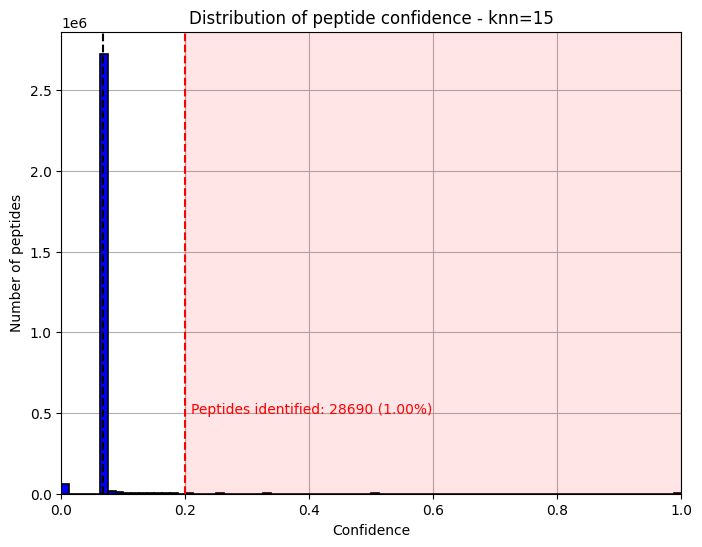

In [41]:
confidence_threshold = 0.2

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(confidence, bins=80, color='blue', edgecolor='black', linewidth=1.2)
ax.set_xlabel('Confidence')
ax.set_ylabel('Number of peptides')
ax.set_title(f'Distribution of peptide confidence - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)

ax.axvline(x=confidence_threshold, color='red', linestyle='--')
ax.axvline(x=1/k, color='black', linestyle='--')
ax.axvspan(confidence_threshold, 1, alpha=0.1, color='red')

identified_count = np.sum(confidence > confidence_threshold)
ax.text(confidence_threshold + 0.01, 5e5, f'Peptides identified: {identified_count} ({identified_count / len(MS1_only) * 100:.2f}%)', color='red')

Let's plot the number of peptides identified for different thresholds.

Text(0, 0.5, 'Percentage of peptides identified (%)')

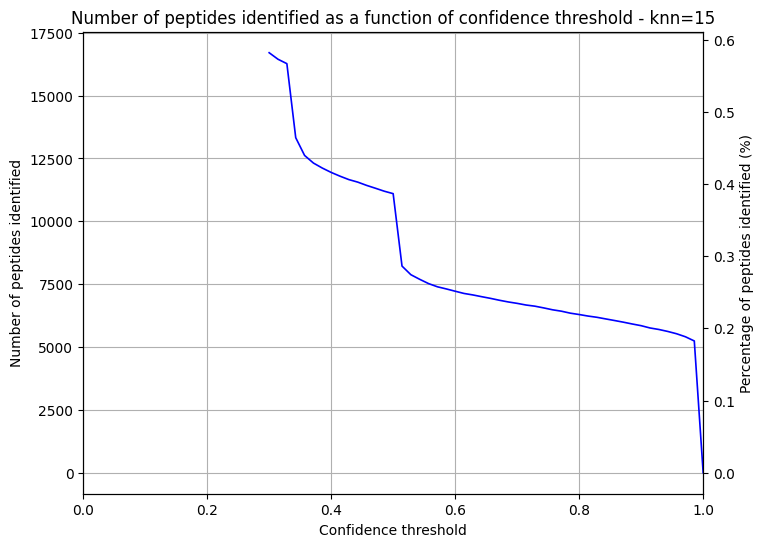

In [42]:
thresholds = np.linspace(0.3, 1, 50)
identified_counts = [np.sum(confidence > threshold) for threshold in thresholds]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, identified_counts, color='blue', linewidth=1.2)

ax.set_xlabel('Confidence threshold')
ax.set_ylabel('Number of peptides identified')
ax.set_title(f'Number of peptides identified as a function of confidence threshold - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)

ax2 = ax.twinx()
ax2.plot(thresholds, np.array(identified_counts) / len(MS1_only) * 100, color='red', linewidth=0) # @NOTE: linewidth=0 to hide the line
ax2.set_ylabel('Percentage of peptides identified (%)')

### False Transfer Rates for MS1 data

Let's compute the false transfer rate (FTR). Recall, all MS1 data is from HeLa cells. So we compute the FTR as the number of identifications in the MS1 data which are not HeLa divided by the total number of identifications in the MS1 data.

First, let's append the species to the precursors.

In [43]:
species_precursor_id = MS2_data['Species'].astype(str).str.cat(MS2_data['PrecursorID'].astype(str), sep='')
MS2_data['PrecursorID'] = species_precursor_id

In [44]:
k = 15

identities, confidence = model.propagate(MS1_only, MS2_data, k_neighbours=k)

Computing peptide embeddings...
Computing prototype embeddings...
Propagating identities based on 15 nearest neighbour prototypes...
Computing identities and confidence...


Let's extract species from the precursor ID.

In [45]:
hela_filter = np.array([identity.startswith('HeLa') for identity in identities])
yeast_filter = np.array([identity.startswith('Yeast') for identity in identities])
ecoli_filter = np.array([identity.startswith('Ecoli') for identity in identities])

Let's plot the false transfer rate as a function of the confidence threshold.

/tmp/ipykernel_20240/811291632.py:25: RuntimeWarning: invalid value encountered in scalar divide
  ftr = np.sum(identified_counts) / np.sum(confidence > threshold)


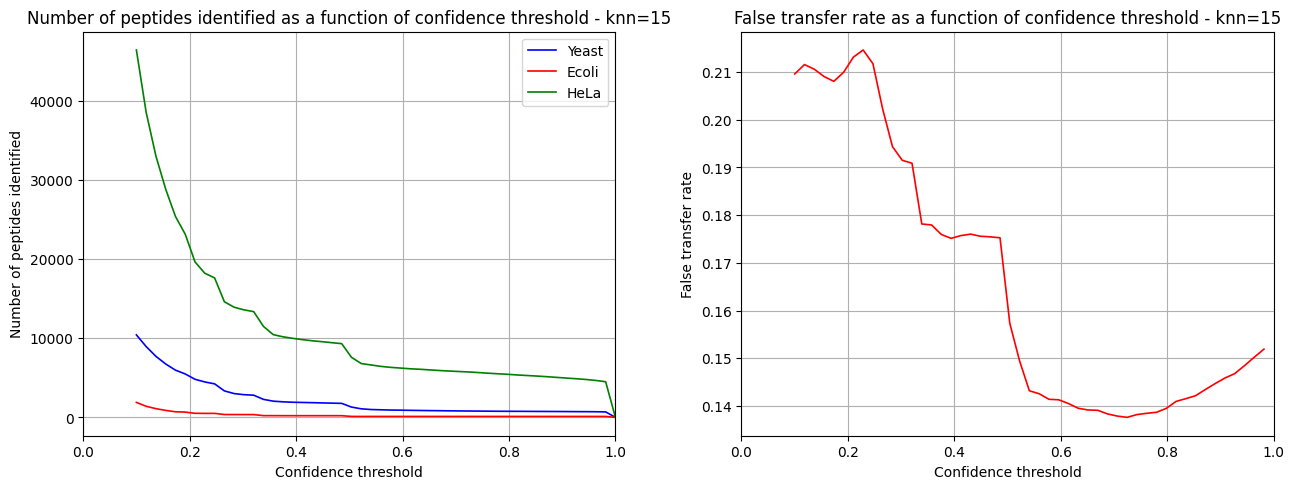

In [46]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=2, nrows=1)
fig.tight_layout(pad=6.0)

confidence_thresholds = np.linspace(0.1, 1, 50)

# number of peptides identified per species
ax = axes[0]

for species_filter, color in zip([yeast_filter, ecoli_filter, hela_filter], ['blue', 'red', 'green']):
    identified_counts = [np.sum(confidence[species_filter] > threshold) for threshold in confidence_thresholds]
    ax.plot(confidence_thresholds, identified_counts, color=color, linewidth=1.2)

ax.set_xlabel('Confidence threshold')
ax.set_ylabel('Number of peptides identified')
ax.set_title(f'Number of peptides identified as a function of confidence threshold - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(['Yeast', 'Ecoli', 'HeLa'])

# false transfer rate
false_transfer_rates = []
for threshold in confidence_thresholds:
    identified_counts = [np.sum(confidence[species_filter] > threshold) for species_filter in [yeast_filter, ecoli_filter]]
    ftr = np.sum(identified_counts) / np.sum(confidence > threshold)
    false_transfer_rates.append(ftr)

ax = axes[1]
ax.plot(confidence_thresholds, false_transfer_rates, color='red', linewidth=1.2)
ax.set_xlabel('Confidence threshold')
ax.set_ylabel('False transfer rate')
ax.set_title(f'False transfer rate as a function of confidence threshold - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)

Let's also compute the proposition of peptides which are not HeLa in the MS2 data.

In [47]:
hela_filter = MS2_data['Species'] == 'HeLa'

non_hela_MS2_proposition = 1 - np.sum(hela_filter) / len(hela_filter)
print(f"MS2 non-HeLa proposition: {non_hela_MS2_proposition * 100:.2f}%")

MS2 non-HeLa proposition: 23.91%
